# *MNIST Training* 


In [0]:
#importing packages
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#Code for importing the Dataset locally
class MNISTDataset:
    """'Bare minimum' class to wrap MNIST numpy arrays into a dataset."""
    def __init__(self, train_imgs, train_lbs, test_imgs, test_lbls, batch_size,
                 to01=True, shuffle=True, seed=None):
        """
        Use seed optionally to always get the same shuffling (-> reproducible
        results).
        """
        self.batch_size = batch_size
        self.train_data = train_imgs
        self.train_labels = train_lbs.astype(np.int32)
        self.test_data = test_imgs
        self.test_labels = test_lbls.astype(np.int32)

        if to01:
            # int in [0, 255] -> float in [0, 1]
            self.train_data = self.train_data.astype(np.float32) / 255
            self.test_data = self.test_data.astype(np.float32) / 255

        self.size = self.train_data.shape[0]

        if seed:
            np.random.seed(seed)
        if shuffle:
            self.shuffle_train()
        self.shuffle = shuffle
        self.current_pos = 0

    def next_batch(self):
        """Either gets the next batch, or optionally shuffles and starts a
        new epoch."""
        end_pos = self.current_pos + self.batch_size
        if end_pos < self.size:
            batch = (self.train_data[self.current_pos:end_pos],
                     self.train_labels[self.current_pos:end_pos])
            self.current_pos += self.batch_size
        else:
            # we return what's left (-> possibly smaller batch!) and prepare
            # the start of a new epoch
            batch = (self.train_data[self.current_pos:self.size],
                     self.train_labels[self.current_pos:self.size])
            if self.shuffle:
                self.shuffle_train()
            self.current_pos = 0
            print("Starting new epoch...")
        return batch

    def shuffle_train(self):
        shuffled_inds = np.arange(self.train_data.shape[0])
        np.random.shuffle(shuffled_inds)
        self.train_data = self.train_data[shuffled_inds]
        self.train_labels = self.train_labels[shuffled_inds]


11493376/11490434 [==============================] - 0s 0us/step


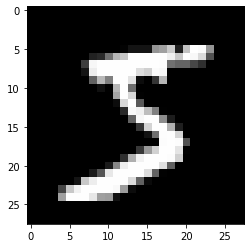

In [2]:
#taking the input
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

plt.imshow(train_images[0], cmap="Greys_r")

data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)

In [0]:
#Initializing the parameters, weights and biases
train_steps = 4000
learning_rate = 0.1
W1 = tf.Variable(np.random.randn(784, 64).astype(np.float32)*0.1)
b1 = tf.Variable(np.zeros(64, dtype=np.float32))
W2 = tf.Variable(np.random.randn(64, 10).astype(np.float32)*0.1)
b2 = tf.Variable(np.zeros(10, dtype=np.float32))

Loss: 2.3649096488952637 Accuracy: 0.125
Starting new epoch...
Loss: 0.3075060248374939 Accuracy: 0.8671875
Starting new epoch...
Loss: 0.26605653762817383 Accuracy: 0.921875
Starting new epoch...
Loss: 0.16742369532585144 Accuracy: 0.9765625
Starting new epoch...
Loss: 0.25598302483558655 Accuracy: 0.9296875
Starting new epoch...
Loss: 0.1805972158908844 Accuracy: 0.9375
Starting new epoch...
Loss: 0.15088316798210144 Accuracy: 0.9609375
Starting new epoch...
Loss: 0.1954081654548645 Accuracy: 0.9453125
Starting new epoch...


<function matplotlib.pyplot.show>

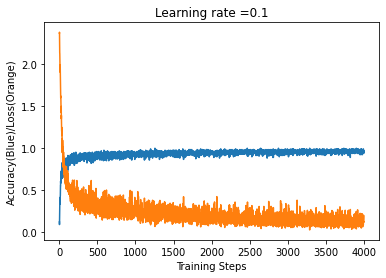

In [4]:
#Training the model

accList = []
lossList = []

#Calculating the gradient
for step in range(train_steps):
    img_batch, lbl_batch = data.next_batch()

    with tf.GradientTape() as tape:

        Z = tf.matmul(img_batch, W1) + b1
        act1 = tf.nn.relu(Z) 
        logits = tf.matmul(act1, W2) + b2

        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=lbl_batch))
        
    grads = tape.gradient(xent, [W1, b1, W2, b2])

    #Updating the weights and biases
    W1.assign_sub(learning_rate * grads[0])
    b1.assign_sub(learning_rate * grads[1])
    W2.assign_sub(learning_rate * grads[2])
    b2.assign_sub(learning_rate * grads[3])

    #Calculating the prediction and accuracy
    preds = tf.argmax(logits, axis=1, output_type=tf.int32)
    acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch),
                             tf.float32))
    
    accList.append(acc)
    lossList.append(xent)

    if not step % 500:
        print("Loss: {} Accuracy: {}".format(xent, acc))

#plotting the change in accuracy and loss against training steps
plt.plot(range(1, train_steps+1) , accList)
plt.plot(range(1, train_steps+1) , lossList)
plt.ylabel('Accuracy(Blue)/Loss(Orange)')
plt.xlabel('Training Steps')
plt.title("Learning rate =" + str(learning_rate))
plt.show

Test accuracy is = 95.92000579833984%
Test prediction for the image = 5


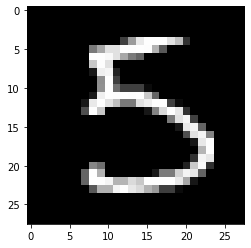

In [5]:
#Calculating the prediction and accuracy on the test set

hidden1 = tf.matmul(data.test_data, W1) + b1
activat1 = tf.nn.relu(hidden1)
test_preds = tf.argmax(tf.matmul(activat1, W2) + b2, axis=1,
                       output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels),
                             tf.float32))
print("Test accuracy is = {}%".format(acc*100))
plt.imshow(test_images[15], cmap="Greys_r")
print("Test prediction for the image = {}".format(test_preds[15]))